# Linear Regression

Our observations each consist of a vector of covariates $(x_{i1},\ldots x_{ip})$ along with corresponding target variable $y_i$. Our model assumes that these satisfy:

$$y_i = \beta_0+\beta_1x_{i1}+\ldots + \beta_px_{ip}+\epsilon_i$$

where $\epsilon_i\sim N(0,\sigma^2)$ are independent. Then if we try to predict targets from covariates using an expression of the form:

$$y_i = \beta_0+\beta_1x_{i1}+\ldots + \beta_px_{ip}$$

we can write the sum of squared errors as:

$$L(\beta) = (Y-X\beta)^\top(Y-X\beta)$$

and the minimising $\beta$ satisfies:


$$\hat{\beta} = \left(X^\top X \right)^{-1} X^\top Y$$

We can implement this using sklearn.linear_model's LinearRegression, on some randomly generated data

In [1]:
import numpy as np
import matplotlib.pyplot as plt

X = 2*np.random.rand(100,1)
y = 4+3*X+np.random.randn(100,1)
X_new = np.array([[0],[2]])

In [2]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X,y)
lin_reg.intercept_, lin_reg.coef_

(array([3.89337848]), array([[3.07132377]]))

In [3]:
lin_reg.predict(X_new)

array([[ 3.89337848],
       [10.03602601]])

This LinearRegression class is based on scipy.linalg.lstsq() which returns the best model parameters $\hat{\beta}$, the residuals,

In [4]:
X_b = np.c_[np.ones((100,1)),X]
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond = 1e-6)
theta_best_svd

array([[3.89337848],
       [3.07132377]])

If we have a large number of features, and/or too many observatiosn to fit in memory, gradient descent can be a better approach to training the model as opposed to computing the exact solution from the closed form expression. For that we need the gradient of the sum of squared errors, which we are minimising.

$$\nabla_\beta L(\beta) = 2X^\top(X\beta - Y)$$

Then for some learning rate $\alpha$ we iteratively compute:

$$\theta^{(k+1)} = \theta^{(k)} - \alpha \nabla_\beta L(\beta)$$

More often some form of stochastic or mini-batch GD will be used to reduce the amount of data utilised at every step. In sklearn.linear_model, SGDRegressor implements linear regression with SGD.

In [5]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter = 1000, tol = 1e-3, penalty = None, eta0 = 0.1)
sgd_reg.fit(X,y.ravel())
sgd_reg.intercept_, sgd_reg.coef_

(array([3.90486411]), array([3.10792854]))

## Polynomial Regression

There is an obvious extension of the above model to include higher order terms in the covariates. For example for degree 2 we have:

$$y_i = \beta_0 + \sum_{k=1}^p \beta_{k}x_{ik} + \sum_{k=1}^p\sum_{k'=1}^p \beta_{kk'}x_{ik}x_{ik'}$$

We can implement this still using a linear model and just feeding in polynomial features.

In [6]:
m = 100
X = 6*np.random.rand(m,1)-3
y = 0.5*X**2+X+2+np.random.randn(m,1)

In [7]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias = False)
X_poly = poly_features.fit_transform(X)

In [8]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.85526726]), array([[0.99105625, 0.50421694]]))

In general we will see such a model perform better than the linear model on training data. We have to distinguissh if this is truly better or just overfitting. We can use an independent test set to do this, and a good way to do this is in conjunction with plotting a learning curve.

In [9]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, Y):
    X_train, X_val, y_train, y_val = train_test_split(X,Y, test_size = 0.2)
    train_err, val_err = [], []
    for m in range(1, len(X_train)):
        model.fit(X = X_train[:m], y = y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val[:m])
        train_err.append(mean_squared_error(y_train[:m], y_train_predict[:m]))
        val_err.append(mean_squared_error(y_val[:m], y_val_predict[:m]))
    plt.plot(np.sqrt(train_err), "r-", linewidth = 2, label = "train")
    plt.plot(np.sqrt(val_err), "b-", linewidth = 3, label = "val")
    plt.legend()
    plt.ylim(0,5)
    plt.xlabel("Training Set Size")
    plt.ylabel("RMSE")

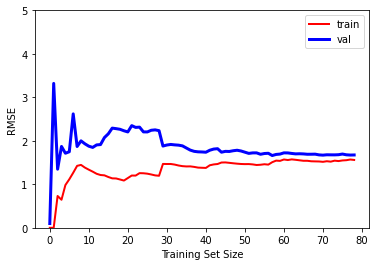

In [10]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

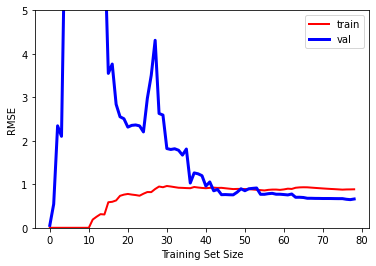

In [11]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
    ("poly_features", PolynomialFeatures(degree=10, include_bias = False)),
    ("lin_reg", LinearRegression())
])

plot_learning_curves(polynomial_regression, X, y)

In general we would expect to see lower training error but a larger gap between training and validation when a model is overfitting.

## Regularised Linear Regression

Idea: Reduce overfitting by contraining the size/complexity of the model. In linear regression we can do this by constraining the value of the weights.

### Ridge Regression

Augment the cost function by adding a term proportional to the squared norm of the coefficient vector. Therefore we minimise the objective:

$$L(\beta) = MSE(\beta) + \alpha \sum_{i=1}^n {\beta_i}^2$$

Note we do not include the bias term $\theta_0$. With ridge resression, as with most regularised models, it is good to scale the inputs before performing regression. We can write the loss as:

$$L(\beta) = (Y-X\beta)^\top(Y-X\beta) + \alpha A\beta^2$$

where $A$ is thee identity matrix with 0 in the first diagonal. Therefore the minising coefficients are:

$$ \hat{\beta} = \left(X^\top X  + \alpha A \right)^{-1} X^\top Y$$

Using closed form:

In [12]:
from sklearn.linear_model import Ridge 
ridge_reg = Ridge(alpha = 1, solver = "cholesky")
ridge_reg.fit(X,y)
ridge_reg.predict([[1.5]])

array([[4.93261876]])

Using SGD:

In [13]:
sgd_reg = SGDRegressor(penalty = "l2")
sgd_reg.fit(X,y.ravel())
sgd_reg.predict([[1.5]])

array([4.90979399])

### Lasso Regression

Augment the cost function by adding a term proportional to the L1 norm of the coefficient vector. Therefore we minimise the objective:

$$L(\beta) = MSE(\beta) + \alpha \sum_{i=1}^n |\beta_i|$$

This has no closed form minimiser. An important characteristic is that this encourages sparsity. In comparison to ridge regression it will set unimportant feature coefficients to zero instead of just making them small. i.e. Lasso performs automated feature selection as well as regression.

In [14]:
from sklearn.linear_model import Lasso 
lasso_reg = Lasso(alpha = 0.1)
lasso_reg.fit(X,y)
lasso_reg.predict([[1.5]])

array([4.88230889])

In [15]:
sgd_reg = SGDRegressor(penalty = "l1")
sgd_reg.fit(X,y.ravel())
sgd_reg.predict([[1.5]])

array([4.92279534])

### Elastic Net Regression

This is a combination of the ridge and lasso penalties where the loss function is:
    
$$L(\beta) = MSE(\beta) + r\alpha \sum_{i=1}^n |\beta_i| + (1-r)\alpha \sum_{i=1}^n {\beta_i}^2$$

In [16]:
from sklearn.linear_model import ElasticNet 
elastic_net = ElasticNet(alpha = 0.1, l1_ratio = 0.5)
elastic_net.fit(X,y)
elastic_net.predict([[1.5]])

array([4.88316737])

# Early Stopping

A different approach to regularisation is to stop GD/SGD once the validation error reaches some threshold, as opposed to minimising the loss. The idea is to stop before the point of overfitting. 

In [17]:
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

poly_scaler = Pipeline([
    ("poly_features", PolynomialFeatures(degree = 1, include_bias = False)),
    ("std_scaler", StandardScaler())
])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.fit_transform(X_val)

sgd_reg = SGDRegressor(max_iter = 1, tol = -np.infty, warm_start = True, penalty = None, 
                       learning_rate = "constant", eta0 = 0.0005)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(10000):
    sgd_reg.fit(X_train_poly_scaled, y_train.ravel())
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)

In [18]:
sgd_reg.predict(poly_scaler.transform([[1.5]]))

array([4.25722189])

# Logistic Regression

Commonly used in classification and can predict the probability that an instance belongs to a particular class. The output of the model is:

$$\hat{p} = \sigma(x^\top\beta)$$

Where:

$$\sigma (t) = \frac{1}{1+\exp(-t)}$$

Then classification is typically done by:

$$\hat{y} = \begin{cases}0 & \text{ if } \hat{p}<0.5 \\ 1 & \text{ if } \hat{p}\geq 0.5  \end{cases}$$


Equivalently:

$$\hat{y} = \begin{cases}0 & \text{ if } x^\top\beta<0 \\ 1 & \text{ if } x^\top\beta \geq 0  \end{cases}$$

This is trained by the cross-entropy classification loss, which is just the negative log-likelihood under this model:

$$L(\beta) = -\frac{1}{m} \sum_{i=1}^m \left[y^i \log\left(\hat{p}^i\right)+\left(1-y^i\right)\log\left(1-\hat{p}^i\right) \right]$$

No closed form minimiser exists but we can use a gradient descent type algorithm, to train with the gradients of the form:

$$\frac{\partial }{\partial \theta_j}L(\theta) = \frac{1}{m}\sum_{i=1}^m \left(\sigma\left(\theta^\top x^i\right)-y^i\right)x_j^i$$

In [24]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename']

In [26]:
x = iris["data"][:,3:] # trying with one feature
y = (iris["target"]== 2).astype(int) # only try to predict in class 2 or not

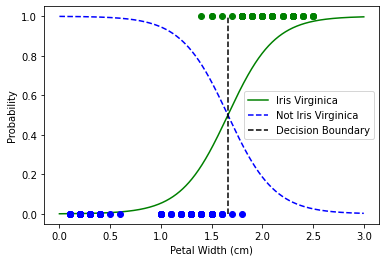

In [76]:
from sklearn.linear_model import LogisticRegression
from scipy.optimize import fsolve
log_reg = LogisticRegression()
log_reg.fit(x,y)

x_new = np.linspace(0,3,1000).reshape(-1,1)
y_prob = log_reg.predict_proba(x_new)
plt.plot(x_new, y_prob[:,1], "g-", label = "Iris Virginica")
plt.plot(x_new, y_prob[:,0], "b--", label = "Not Iris Virginica")
plt.xlabel("Petal Width (cm)")
plt.ylabel("Probability")
class0 = [x[i][0] for i in range(len(x)) if y[i] == 0]
class1 = [x[i][0] for i in range(len(x)) if y[i] == 1]
proba_fn = lambda x: log_reg.predict_proba([x])[0][0]-0.5
bdry = -log_reg.intercept_[0]/log_reg.coef_[0]
plt.plot([bdry]*2, [0,1], "k--", label = "Decision Boundary")
plt.plot(class0, [0]*len(class0), "bo")
plt.plot(class1, [1]*len(class1), "go")
plt.legend()

In [77]:
x = iris["data"][:,2:] # trying with two features
y = (iris["target"]== 2).astype(int) # only try to predict in class 2 or not

Text(0, 0.5, 'Petal Width')

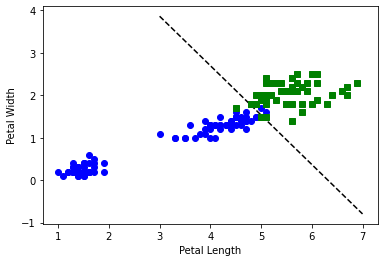

In [92]:
log_reg = LogisticRegression()
log_reg.fit(x,y)
intercept = log_reg.intercept_
theta1 = log_reg.coef_[0][0]
theta2 = log_reg.coef_[0][1]
x1 = np.linspace(3,7,1000)
x2 = (-intercept-theta1*x1)/theta2
plt.plot(x1,x2, "k--", label = "Decision Boundary")

class0 = [x[i] for i in range(len(x)) if y[i] == 0]
class1 = [x[i] for i in range(len(x)) if y[i] == 1]
plt.plot([val[0] for val in class0], [val[1] for val in class0], "bo", label = "Not Iris Virginica")
plt.plot([val[0] for val in class1], [val[1] for val in class1], "gs", label = "Iris Virginica")
plt.xlabel("Petal Length")
plt.ylabel("Petal Width")


Logistic Regression extends naturally to the multicalss problem by the use of the softmax function to compute probabilities for each class, instead of just sigmoid compuhting one probability as in Logistic Regression. Corresponding there is a paramter vector $\beta^k$ for each of the $k$ classes instead of just one. 

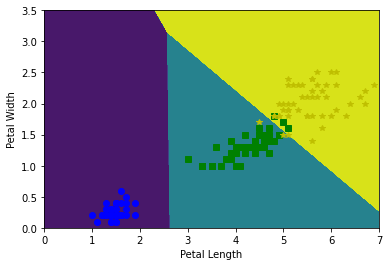

In [104]:
x= iris["data"][:, (2,3)]
y = iris["target"]

softmax_reg = LogisticRegression(multi_class = "multinomial", solver = "lbfgs", C=10)
softmax_reg.fit(x,y)

class0 = [x[i] for i in range(len(x)) if y[i] == 0]
class1 = [x[i] for i in range(len(x)) if y[i] == 1]
class2 = [x[i] for i in range(len(x)) if y[i] == 2]

plt.plot([val[0] for val in class0], [val[1] for val in class0], "bo", label = "Not Iris Virginica")
plt.plot([val[0] for val in class1], [val[1] for val in class1], "gs", label = "Iris Virginica")
plt.plot([val[0] for val in class2], [val[1] for val in class2], "y*", label = "Not Iris Virginica")
plt.xlabel("Petal Length")
plt.ylabel("Petal Width")


xx,yy = np.meshgrid(np.linspace(0,7,1000), np.linspace(0,3.5,1000))
z = softmax_reg.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.contourf(xx,yy,z)